# Section 1:  Data Analysis and Pre-Processing

## Introduction to short course data and problem

The goal of the problem is to predict the probability of low-level vorticity exceeding a certain threshold up to ahead given a storm with a simulated radar reflectivity > 40 dBZ and the associated surface wind and temperature fields. 

__Input fields in the netCDF data:__

* REFL_COM_curr (composite reflectivity)

* U10_curr (10 m west-east wind component in m/s)

* V10_curr (10 m south-north wind component in m/s)

* T2_curr (2 m temperature in Kelvin)

__Prediction field:__

* RVORT1_MAX_future (hourly maximum vertical vorticity at 1 km Above ground level in s-1)

__Other fields of note:__

* time: valid time of storm image

* i and j: row and column array indices from original WRF model grid

* x and y: projection coordinates in m

* masks: binary grid showing where storm outline is. Aggregate stats in csv file are extracted from only positive grid points in masks.

## Reading meteorological data files with pandas and xarray

First we need to import the libraries used in this section

In [1]:
%matplotlib inline
import numpy as np
import netCDF4 as nc
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore

import glob
import os

##### Lets find the CSV files

In [2]:
# set the path to the data as a string
path = "data/track_data_ncar_ams_3km_csv_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.csv"))

##### Now lets read in the CSV files using Pandas

In [3]:
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
print (df.keys())

Index([u'Step_ID', u'Track_ID', u'Ensemble_Name', u'Ensemble_Member',
       u'Run_Date', u'Valid_Date', u'Forecast_Hour', u'Valid_Hour_UTC',
       u'Duration', u'Centroid_Lon', u'Centroid_Lat', u'Centroid_X',
       u'Centroid_Y', u'Storm_Motion_U', u'Storm_Motion_V', u'REFL_COM_mean',
       u'REFL_COM_max', u'REFL_COM_min', u'REFL_COM_std',
       u'REFL_COM_percentile_10', u'REFL_COM_percentile_25',
       u'REFL_COM_percentile_50', u'REFL_COM_percentile_75',
       u'REFL_COM_percentile_90', u'U10_mean', u'U10_max', u'U10_min',
       u'U10_std', u'U10_percentile_10', u'U10_percentile_25',
       u'U10_percentile_50', u'U10_percentile_75', u'U10_percentile_90',
       u'V10_mean', u'V10_max', u'V10_min', u'V10_std', u'V10_percentile_10',
       u'V10_percentile_25', u'V10_percentile_50', u'V10_percentile_75',
       u'V10_percentile_90', u'T2_mean', u'T2_max', u'T2_min', u'T2_std',
       u'T2_percentile_10', u'T2_percentile_25', u'T2_percentile_50',
       u'T2_percentile_75', u

In [4]:
df1 = df.loc[:,['Step_ID', 'U10_mean', 'V10_mean', 'T2_mean']]
print (type(df1))

<class 'pandas.core.frame.DataFrame'>


In [5]:
df1['T2_mean'].mean()

289.4654436647756

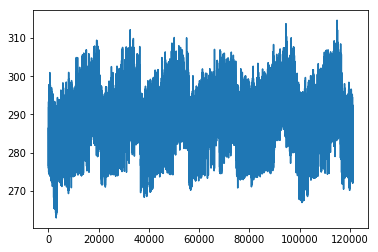

In [6]:
df1['T2_mean'].plot()

##### Lets find the netCDF files

In [7]:
# set the path to the data as a string
path = "data/track_data_ncar_ams_3km_nc_small/"

# create a list of the files and print it out
files = sorted(glob.glob(path+"/*.nc"))
#print (files)

 ##### Let's read in the first file in the list and see what is in the files.

In [8]:
#  Open the file with the Netcdf library for reading and then close it
nf = nc.Dataset(files[0], "r")
print (nf)
nf.close()

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    title: NCARSTORM Storm Patches for run 20101024-0000 member d01
    object_variable: REFL_COM
    dimensions(sizes): p(1472), row(32), col(32)
    variables(dimensions): int32 p(p), int32 row(row), int32 col(col), float32 lon(p,row,col), float32 lat(p,row,col), int32 i(p,row,col), int32 j(p,row,col), float32 x(p,row,col), float32 y(p,row,col), int32 masks(p,row,col), int32 time(p), float32 centroid_lon(p), float32 centroid_lat(p), float32 centroid_i(p), float32 centroid_j(p), int32 track_id(p), int32 track_step(p), float32 REFL_COM_curr(p,row,col), float32 U10_curr(p,row,col), float32 V10_curr(p,row,col), float32 T2_curr(p,row,col), float32 RVORT1_MAX_future(p,row,col), float32 HAIL_MAXK1_future(p,row,col)
    groups: 



##### Lets open a file with xarray and index into it

In [9]:
xf = xr.open_dataset(files[0])
print (xf)

<xarray.Dataset>
Dimensions:            (col: 32, p: 1472, row: 32)
Coordinates:
  * p                  (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 ...
  * row                (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
  * col                (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
Data variables:
    lon                (p, row, col) float32 ...
    lat                (p, row, col) float32 ...
    i                  (p, row, col) int32 ...
    j                  (p, row, col) int32 ...
    x                  (p, row, col) float32 ...
    y                  (p, row, col) float32 ...
    masks              (p, row, col) int32 ...
    time               (p) datetime64[ns] ...
    centroid_lon       (p) float32 ...
    centroid_lat       (p) float32 ...
    centroid_i         (p) float32 ...
    centroid_j         (p) float32 ...
    track_id           (p) int32 ...
    track_step         (p) int32 ...
    REFL_COM_curr      (p, row, col) float32 ...


In [10]:
T = xf['T2_curr']
print (T)
print ("Dimensions:",T.dims)
print ("Coords:",T.coords)
print ("Attributes:",T.attrs)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
[1507328 values with dtype=float32]
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    long_name:  T2
    units:      
('Dimensions:', (u'p', u'row', u'col'))
('Coords:', Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...)
('Attributes:', OrderedDict([(u'long_name', u'T2'), (u'units', u'')]))


##### Indexing and Selecting Data Ranges

In [11]:
print (T[0,0,1].values)
print (T[0:5,0,1].values)
print (T.sel(p=slice(0,5),col=1,row=0).values)
print (T.sel(p=4,col=1,row=0).values)
print (T.sel(row=0,col=1,p=4).values)

293.50546
[293.50546 293.06808 294.17676 294.1718  292.86124]
[293.50546 293.06808 294.17676 294.1718  292.86124 293.2119 ]
292.86124
292.86124


## Data transformations 

In [12]:
T.where(T>290)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[293.5103 , 293.50546, ..., 292.29697, 292.0353 ],
        [293.73416, 293.6699 , ..., 292.3496 , 292.35492],
        ...,
        [295.75235, 295.77435, ..., 292.0231 , 291.988  ],
        [295.861  , 294.75845, ..., 291.97015, 292.3123 ]],

       [[293.1342 , 293.06808, ..., 291.42545, 291.39578],
        [293.092  , 293.06543, ..., 291.25757, 291.27454],
        ...,
        [292.41833, 292.42923, ..., 292.32608, 291.91068],
        [292.36642, 292.40335, ..., 292.17728, 292.01117]],

       ...,

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan],
        ...,
        [      nan,       nan, ...,       nan,

In [13]:
T>290

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]],

       ...,

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col   

In [14]:
T.round(0)

<xarray.DataArray 'T2_curr' (p: 1472, row: 32, col: 32)>
array([[[294., 294., ..., 292., 292.],
        [294., 294., ..., 292., 292.],
        ...,
        [296., 296., ..., 292., 292.],
        [296., 295., ..., 292., 292.]],

       [[293., 293., ..., 291., 291.],
        [293., 293., ..., 291., 291.],
        ...,
        [292., 292., ..., 292., 292.],
        [292., 292., ..., 292., 292.]],

       ...,

       [[284., 284., ..., 285., 285.],
        [285., 285., ..., 285., 285.],
        ...,
        [286., 286., ..., 282., 283.],
        [286., 286., ..., 282., 283.]],

       [[278., 279., ..., 275., 276.],
        [279., 281., ..., 274., 275.],
        ...,
        [283., 283., ..., 279., 279.],
        [283., 284., ..., 281., 281.]]], dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...
  * row      (row) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * col      (col) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [15]:
T.mean(dim=['col','row','p']).values


array(285.3192, dtype=float32)

In [16]:
print (T.min())
print (T.min(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(261.804199)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.46454, 290.80118, 291.36282, ..., 279.1897 , 277.76544, 263.59863],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [17]:
print (T.max())
print (T.max(dim=['col','row']))

<xarray.DataArray 'T2_curr' ()>
array(303.617371)
<xarray.DataArray 'T2_curr' (p: 1472)>
array([296.53342, 295.33218, 295.74823, ..., 284.14084, 286.5378 , 285.0278 ],
      dtype=float32)
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


In [18]:
print (T.groupby('p').reduce(np.percentile, q=5))

<xarray.DataArray 'T2_curr' (p: 1472)>
array([291.845779, 291.113249, 292.001576, ..., 279.554179, 280.1492  ,
       272.691624])
Coordinates:
  * p        (p) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 ...


## Exploratory visulization with matplotlib 

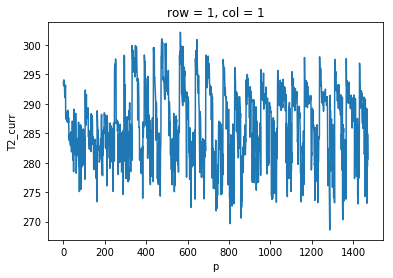

In [19]:
T[:,1,1].plot()

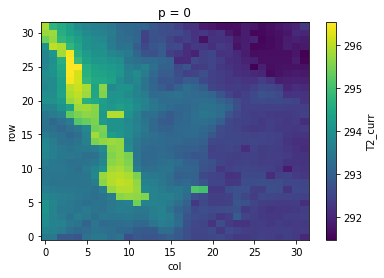

In [20]:
T.isel(p=0).plot()

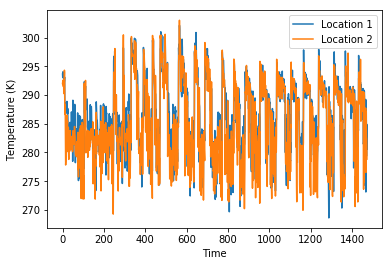

In [21]:
plt.plot(xf['p'],T[:,1,1], label='Location 1')
plt.plot(xf['p'],T[:,30,30], label='Location 2')
plt.ylabel('Temperature (K)')
plt.xlabel('Time')
plt.legend()

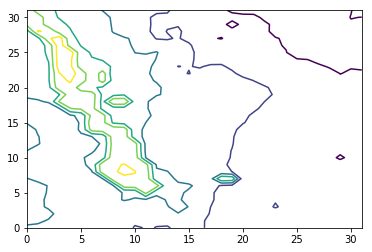

In [22]:
plt.contour(T[0,:,:])

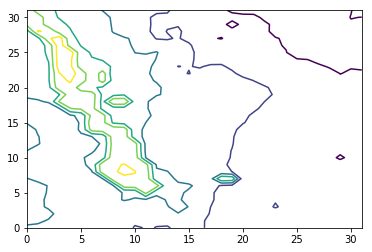

In [23]:
plt.contour(T.sel(p=0))


<a list of 10 text.Text objects>

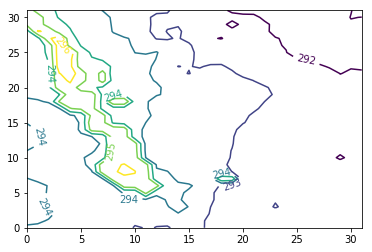

In [24]:
cs = plt.contour(T.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)

In [25]:
V = xf['V10_curr']
U = xf['U10_curr']
r = xf['row']
c = xf['col']

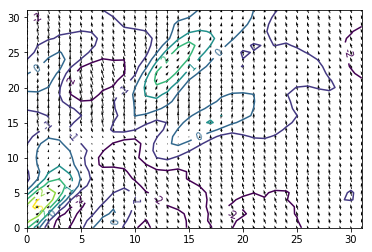

In [26]:
cs = plt.contour(U.sel(p=0))
plt.clabel(cs, fmt='%.0f', inline=True)
plt.quiver(r, c, U.sel(p=0), V.sel(p=0), pivot='middle')

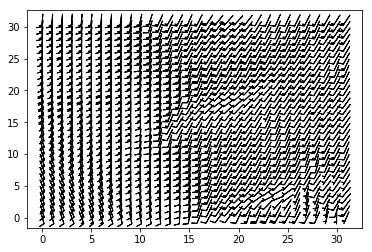

In [27]:
plt.barbs(r, c, U.sel(p=200), V.sel(p=200), length=5, pivot='middle')

# Preparing data for the turorial

##### Declare all of the input and output variables

In [28]:
run_times = []
valid_times = []
# List of input variables
in_vars = ["REFL_COM_curr",
           "U10_curr", "V10_curr"]
# List of output variables
out_vars = ["RVORT1_MAX_future"]
in_data = []
out_data = []

##### Loop through each file and extract the relevant variables

In [29]:
for f in files[0:5]:
    run_time = pd.Timestamp(f.split("/")[-1].split("_")[1])
    ds = xr.open_dataset(f)
    in_data.append(np.stack([ds[v].values for v in in_vars], axis=-1))
    out_data.append(np.stack([ds[v].values for v in out_vars], axis=-1))
    valid_times.append(ds["time"].values)
    run_times.append([run_time] * in_data[-1].shape[0])
    ds.close()

##### Stack the  data into single arrays instead of lists of arrays

In [30]:
all_in_data = np.vstack(in_data)
all_out_data = np.vstack(out_data)
all_run_times = np.concatenate(run_times)
all_valid_times = np.concatenate(valid_times)

##### Deallocate the lists of arrays to save memory

In [31]:
del in_data[:], out_data[:], run_times[:], valid_times[:]
del in_data, out_data, run_times, valid_times

In [32]:
max_vort = all_out_data[:, :, :, 0].max(axis=-1).max(axis=-1)
vort_thresh = 0.008
print(percentileofscore(max_vort, vort_thresh))
vort_labels = np.where(max_vort > vort_thresh, 1, 0)

98.52216748768473


Text(0,0.5,u'Cumulative Distribution')

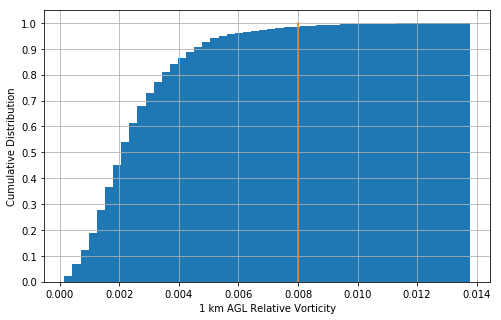

In [33]:
plt.figure(figsize=(8, 5))
plt.hist(max_vort, bins=50, cumulative=True, density=True)
plt.plot(np.ones(10) * vort_thresh, np.linspace(0, 1, 10))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid()
plt.xlabel("1 km AGL Relative Vorticity")
plt.ylabel("Cumulative Distribution")

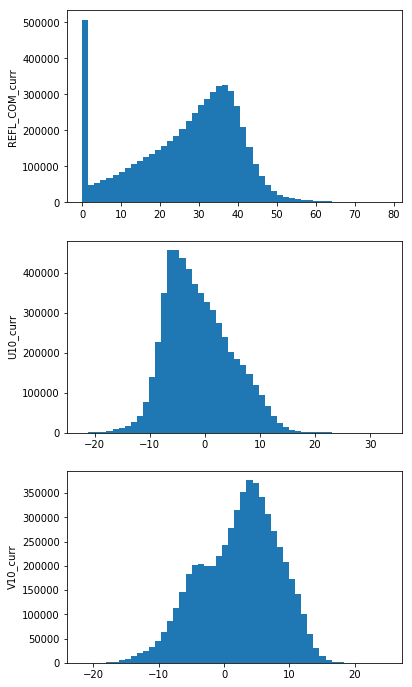

In [34]:
fig, axes = plt.subplots(all_in_data.shape[-1], 1, figsize=(6, all_in_data.shape[-1] * 4))
for a, ax in enumerate(axes):
    ax.hist(all_in_data[:, :, :, a].ravel(), 50)
    ax.set_ylabel(in_vars[a])

Text(0.5,1,u'Storm Example 700 Valid 2010-10-25 00:00')

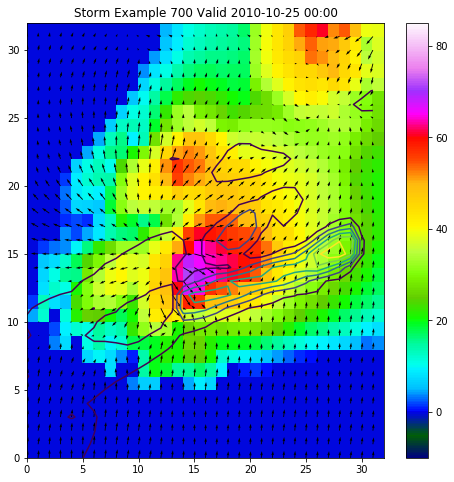

In [35]:
rot_ex = max_vort.argmax()
plt.figure(figsize=(8, 8))
plt.pcolormesh(all_in_data[rot_ex, :, :, 0], cmap="gist_ncar", vmin=-10, vmax=85)
plt.colorbar()
plt.quiver(all_in_data[rot_ex, :, :, 1], all_in_data[rot_ex, :, :, 2])
plt.contour(all_out_data[rot_ex, :, :, 0])
plt.title("Storm Example {0} Valid ".format(rot_ex) + pd.Timestamp(all_valid_times[rot_ex]).strftime("%Y-%m-%d %H:%M")) 

### Separating into training and test sets 

##### By date

In [36]:
split_date = pd.Timestamp("2010-10-28")
train_indices = np.where(all_run_times < split_date)[0]
test_indices = np.where(all_run_times >= split_date)[0]
print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

('Size of training set: ', 1472)
('Size of test set: ', 4009)


##### By random index

In [37]:
from random import shuffle

percent_train = .8

indices = range(len(U.coords['p']))
shuffle(indices)

split = int(len(U.coords['p'])*.8)
print ("Splitting on index: ",split)

train_indices = indices[0:split]
test_indices = indices[split:len(U.coords['p'])-1]

print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

#print (train_indices)
#print (test_indices)


('Splitting on index: ', 1177)
('Size of training set: ', 1177)
('Size of test set: ', 294)


##### By index

In [38]:
percent_train = .8

split = int(len(U.coords['p'])*.8)
print ("Splitting on index: ",split)

train_indices = np.array(range(0,split))
test_indices = np.array(range(split, len(U.coords['p'])))
print ("Size of training set: ",len(train_indices))
print ("Size of test set: ",len(test_indices))

('Splitting on index: ', 1177)
('Size of training set: ', 1177)
('Size of test set: ', 295)


##### Normalizing patch data
Normalizing the data allows observational data to be more easily predicted

In [39]:
from sklearn.preprocessing import MinMaxScaler

U = xf['U10_curr']

U = U.stack(z=('row','col'))
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(U)
ua_norm = scaler.transform(U)

ua_norm.shape

(1472, 1024)

#####  Using prinicpal component analysis to reduce the dimensionality of the different fields

In [40]:
from sklearn.decomposition import PCA

pc_objs = []
means = []
sds = []

num_comps = 1
num_vars = ua_norm.shape[0]
pc_train_data = np.zeros((train_indices.size, ua_norm.shape[1]), dtype=np.float32)
pc_test_data = np.zeros((test_indices.size, ua_norm.shape[1]), dtype=np.float32)
for v in range(num_vars):
    pc_objs.append(PCA(n_components=num_comps))
    #var_data = ua_norm[:, v].reshape(-1, ua_norm.shape[0] * ua_norm.shape[1])
    var_data = ua_norm
    pc_train_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].fit_transform(var_data[train_indices])
    pc_test_data[:, v * num_comps: (v + 1) * num_comps] = pc_objs[v].transform(var_data[test_indices])
    del var_data